# Part 1: Model Configuration and Training

In [19]:
# Importing libraries
import pandas as pd
import numpy as np
import math
import cv2

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D
from keras.optimizers import Adam
from keras.layers import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model

import pydot
import pydotplus
from keras.utils.vis_utils import model_to_dot

import os.path
from os import path

import tkinter as tk
from tkinter import *
from PIL import Image, ImageTk
from imutils import resize

print('Libraries imported successfully!')

Libraries imported successfully!


In [20]:
# Project Hyperparameters
SCALAR = 255
ACTIVATION = 'relu'
ACTIVATION_2 = 'softmax'
LOSS_FUNC = 'categorical_crossentropy'
LEARNING_RATE = 0.0001
DECAY=1e-6
STEPS = 28709 // 64
VAL_STEPS = 7178 // 64
EPOCHS = 50

In [21]:
# Face bounding box properties in a dictionary
dict_faces = {
    0: "Angry", 
    1: "Disgusted", 
    2: "Fearful", 
    3: "Happy", 
    4: "Neutral", 
    5: "Sad", 
    6: "Surprised"
}

In [22]:
## Emoji dataset config.

# Initialize image data generator to apply image scaling
obj_train = ImageDataGenerator(rescale=1./SCALAR)
obj_val = ImageDataGenerator(rescale=1./SCALAR)

# Define train and test dataset directory
dir_t = 'data_source/train'
dir_v = 'data_source/test'

print('Loading images and classes...')

# Load and configure train data
train_data = obj_train.flow_from_directory(dir_t,target_size=(48,48),batch_size=64,color_mode="grayscale",class_mode='categorical')

# Load and configure test/validation data
val_data = obj_val.flow_from_directory(dir_v,target_size=(48,48),batch_size=64,color_mode="grayscale",class_mode='categorical')

print('Image loaded successfully...')

Loading images and classes...
Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Image loaded successfully...


In [23]:
## Design a CNN model

'''
Model structure:
----------------
Conv2D layer: kernel number 32, kernel size 3,3, relu activation, accepted input shape 48,48,1
Conv2D layer: kernel number 64, kernel size 3,3, relu activation
Max pooling layer: pooling window size 2,2
Apply dropout: rate 0.20

Conv2D layer: kernel number 128, kernel size 3,3, relu activation
Max pooling layer: pooling window size 2,2
Apply dropout: rate 0.20

Fully conected dense layer 1
Fully connected dense layer 2
'''

def CNN():
    # Initialize a keras sequential model
    model = Sequential()

    # Set dropout rate
    rate_1 = 0.20
    rate_2 = 0.22
    rate_3 = 0.35

    # 2D convolution layer 1
    model.add(Conv2D(
        32, 
        kernel_size=(3, 3), 
        activation=ACTIVATION, 
        input_shape=(48,48,1)))

    # 2D convolution layer 2: apply on output of previous Conv2D
    model.add(Conv2D(
        64, 
        kernel_size=(3, 3), 
        activation=ACTIVATION))

    # Apply max pooling on the output of previous Conv2D
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Apply dropout, rate_1 = 0.20
    # It will disable 20% neural connections
    model.add(Dropout(rate_1))

    # 2D convolution layer 3: apply on output of previous Conv2D
    model.add(Conv2D(
        128, 
        kernel_size=(3, 3), 
        activation=ACTIVATION))

    # Apply max pooling on the output of previous Conv2D 
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # 2D convolution layer 4: apply on output of previous Conv2D
    model.add(Conv2D(
        128, 
        kernel_size=(3, 3), 
        activation=ACTIVATION))

    # Apply max pooling on the output of previous Conv2D
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Apply dropout, rate_1 = 0.22
    model.add(Dropout(rate_2))

    # Fully connected layer 1: Flatten pixel values
    # It converts multi-dimensional data into one dimension
    model.add(Flatten())
    model.add(Dense(1024, activation=ACTIVATION))

    # Apply dropout, rate_1 = 0.35
    model.add(Dropout(rate_3))

    # Fully connected layer 2
    model.add(Dense(7, activation=ACTIVATION_2))
    
    return model

Generating a CNN model...
CNN model generated successfully.
Model structure:



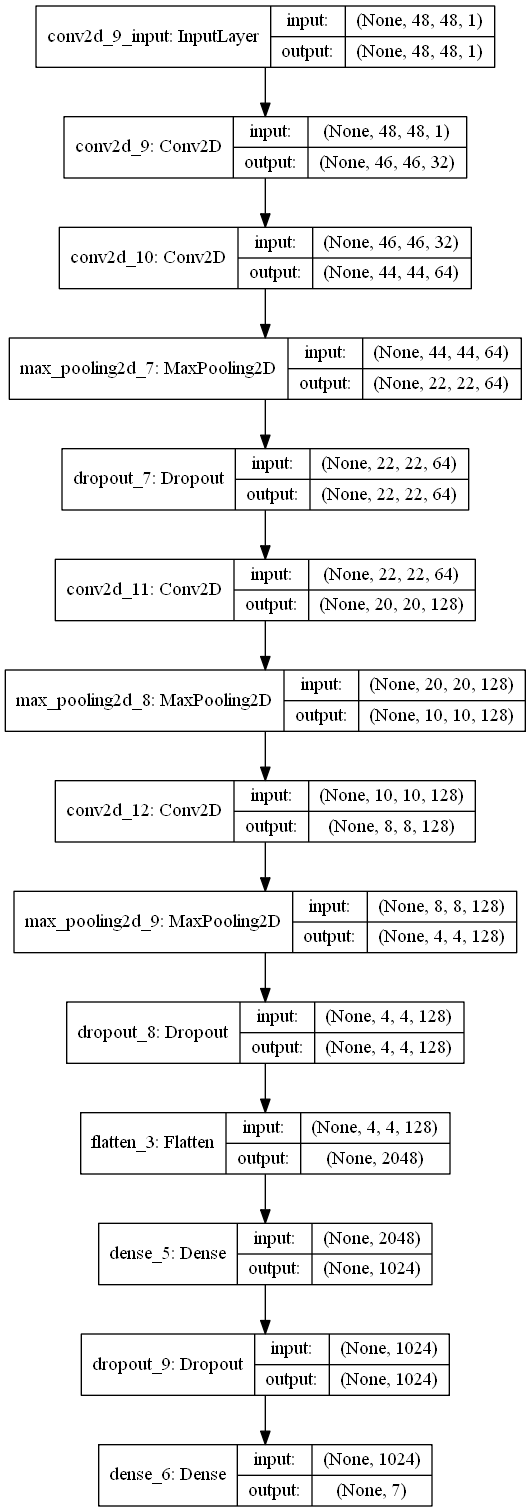

In [24]:
print('Generating a CNN model...')

model = CNN()

print('CNN model generated successfully.')
print('Model structure:\n')

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [25]:
# Configure model with necessary hyperparameters:
# loss function, optimizer, learning rate, weight decay
has_path = path.exists('model.h5')

if has_path == False:
    model.compile(
        loss=LOSS_FUNC,
        optimizer=Adam(lr=LEARNING_RATE, decay=DECAY),metrics=['accuracy'])

    print('Model compiled.\n')
else:
    print('Model is already trained.')
    
print(model.summary())

Model is already trained.
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 44, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 20, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)          

In [26]:
# Apply fit generator and save generated model weights
# It fits the model with previous configurations and assign others steps and epochs to the model
has_path = path.exists('model.h5')

if has_path == False:
    print('Training started for ' + str(EPOCHS) + ' epochs.\n')
    model_fitted = model.fit_generator(
        train_data, # assign train images
        steps_per_epoch=STEPS, # set number of iterations for each epoch
        epochs=EPOCHS, # set total number of epochs
        validation_data=val_data, # set validation data set
        validation_steps=VAL_STEPS
    )

    # Save trained model
    model.save_weights('model.h5')
    print('Trained model saved.')
    
else:
    model.load_weights('model.h5')
    print('Trained model loaded.')

Trained model loaded.


# Part 2: Face Bounding box Detection

In [27]:
##Referred https://data-flair.training/blogs/create-emoji-with-deep-learning/

cv2.ocl.setUseOpenCL(False)
cap = cv2.VideoCapture(0)

emoji_dist={0:"./emojis/angry.png",1:"./emojis/disgusted.png",2:"./emojis/fearful.png",3:"./emojis/happy.png",4:"./emojis/neutral.png",5:"./emojis/sad.png",6:"./emojis/surprised.png"}

while True:
    ret, frame = cap.read()
    
    if not ret:
        break
    
    bounding_box = cv2.CascadeClassifier('C:/Users/medha/anaconda3/envs/deeplearning/Library/etc/haarcascades/haarcascade_frontalface_default.xml')
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)#COLOR_BGR2GRAY
    num_faces = bounding_box.detectMultiScale(gray_frame,scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in num_faces:
        cv2.rectangle(frame, (x, y-50), (x+w, y+h+10), (255, 0, 0), 2)
        roi_gray_frame = gray_frame[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray_frame, (48, 48)), -1), 0)
        emotion_prediction = model.predict(cropped_img)
        mindex = int(np.argmax(emotion_prediction))
        cv2.putText(frame, dict_faces[mindex], (x+20, y-60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        test_image=cv2.imread(emoji_dist[mindex])
        image_resize=resize(test_image,height=120,width=120)
        t_image=cv2.cvtColor(image_resize,cv2.COLOR_BGR2BGRA)
        
        
        frame_h,frame_w,frame_c=frame.shape
        overlay=np.zeros((frame_h,frame_w,4),dtype='uint8')
        t_image_h,t_image_w,t_image_c=t_image.shape
        
        frame=cv2.cvtColor(frame,cv2.COLOR_BGR2BGRA)
        
        for i in range(0,t_image_h):
            for j in range(0,t_image_w):
                if(t_image[i,j][3]!=0):
                    overlay[i+10,j+10]=t_image[i,j]
        cv2.addWeighted(overlay,0.8,frame,0.4,0,frame)
        

    cv2.imshow('Video', cv2.resize(frame,(1200,860),interpolation = cv2.INTER_CUBIC))
    
    k=cv2.waitKey(10) & 0xFF
    if k==27:
        break
        
cap.release()
cv2.destroyAllWindows()